In [2]:
%%capture
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets
from keras.utils import to_categorical

2025-11-25 10:11:25.683601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-25 10:11:25.683662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-25 10:11:25.685035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-25 10:11:25.692762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [4]:
# source: pdg.ipynb
def pgd_attack(model, loss_fn, images, labels, epsilon, a, k):  
    x = images + np.random.uniform(-epsilon, epsilon, images.shape)
    x = np.clip(x, 0, 1) # verifier que la randomisation n'a pas fait sortir les pixels de [0, 1]

    for i in range(k):
      # convertir les donnes en donnes facilement manipulables par tf
      x = tf.convert_to_tensor(x, dtype=tf.float32)
      y_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)
      
      # pareil que FGSM
      with tf.GradientTape() as tape:
        tape.watch(x)
        outputs = model(x)
        loss = loss_fn(y_tensor, outputs)
      
      grad = tape.gradient(loss, x).numpy()

      x = x.numpy()
      x += a * np.sign(grad) # avancer d'un petit pas, ici a = 0.01, tandis qu'avec fgsm, on avancait d'un seul coup, d'un facteur epsilon 
                                  # for img_idx in range(len(x)): x[img_idx] += self.a * np.sign(grad[img_idx]) # cache ce type de boucle
      # normaliser les donnees
      x = np.clip(x, images - epsilon, images + epsilon)
      x = np.clip(x, 0, 1)

    return x

In [5]:
def load_data():
    (_, _), (test_data, test_labels) = datasets.mnist.load_data()

    test_data = test_data / 255.0
    test_data = test_data[..., tf.newaxis]
    test_data = tf.cast(test_data, tf.float32)

    test_labels = tf.one_hot(test_labels, 10)
    return test_data, test_labels

In [6]:
model_logit = tf.keras.models.load_model('/work/mnist_classifier_model-no-softmax.h5')
xb, yb = load_data()
x_batch = np.array([xb[10], xb[2], xb[1], xb[32], xb[4], xb[15], xb[21], xb[0], xb[61], xb[9]])
y_batch = np.array([yb[10], yb[2], yb[1], yb[32], yb[4], yb[15], yb[21], yb[0], yb[61], yb[9]])

2025-11-25 10:11:29.443300: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (34)


[source](https://github.com/LTS4/universal/blob/master/python/universal_pert.py)

In [7]:
def proj_lp(v, xi, p):

    # Project on the lp ball centered at 0 and of radius xi

    # SUPPORTS only p = 2 and p = Inf for now
    if p == 2:
        v = v * min(1, xi/np.linalg.norm(v.flatten())) # pas de 1 dans les parentheses de flatten
        # v = v / np.linalg.norm(v.flatten(1)) * xi
    elif p == np.inf:
        v = np.sign(v) * np.minimum(abs(v), xi)
    else:
         raise ValueError('Values of p different from 2 and Inf are currently not supported...')

    return v

In [ ]:
def universal_perturbation(dataset, label, model, delta=0.2, max_iter_uni = np.inf, xi=10, p=np.inf, shape=(28,28,1), epsilon=0.3, a=0.01, k=20):
    """
    :param dataset: Images of size MxHxWxC (M: number of images)

    :param model: feedforward function (input: images, output: values of activation BEFORE softmax).

    #:param grads: gradient functions with respect to input (as many gradients as classes).

    :param delta: controls the desired fooling rate (default = 80% fooling rate)

    :param max_iter_uni: optional other termination criterion (maximum number of iteration, default = np.inf)

    :param xi: controls the l_p magnitude of the perturbation (default = 10)

    :param p: norm to be used (FOR NOW, ONLY p = 2, and p = np.inf ARE ACCEPTED!) (default = np.inf)

    :return: the universal perturbation.
    """

    v = np.zeros((1, shape[0], shape[1], shape[2]), dtype=np.float32) # au lieu de v=0 
    fooling_rate = 0.0
    num_images =  np.shape(dataset)[0] # The images should be stacked ALONG FIRST DIMENSION

    itr = 0
    while fooling_rate < 1-delta and itr < max_iter_uni:
        # Shuffle the dataset
        np.random.shuffle(dataset)

        print ('Starting pass number', itr)

        # Go through the data set and compute the perturbation increments sequentially
        iter = 0
        for k in range(0, num_images):
            cur_img = dataset[k:(k+1), :, :, :]
            cur_label = label[k]

            if int(np.argmax(np.array(model(cur_img)).flatten())) == int(np.argmax(np.array(model(cur_img+v)).flatten())):
                print('>> k = ', k, ', pass #', itr)

                # Compute adversarial perturbation

                #print(cur_img.shape)
                #print(cur_label.shape)

                cur_img_pert = pgd_attack(model, loss_fn, cur_img, cur_label, epsilon, a, k)
                perturbation = np.array(cur_img_pert - cur_img) # image perturbee - image = perturbation
                dr = np.clip(perturbation, 0, 1)

                iter += 1
                # Make sure it converged...
                if iter < 10-1:
                    v = v + dr

                    # Project on l_p ball
                    v = proj_lp(v, xi, p)

        itr = itr + 1

        # Perturb the dataset with computed perturbation
        dataset_perturbed = dataset + v

        est_labels_orig = np.zeros((num_images))
        est_labels_pert = np.zeros((num_images))

        batch_size = 100
        num_batches = int(np.ceil(1.0*num_images / batch_size))

        # Compute the estimated labels in batches
        for ii in range(0, num_batches):
            m = (ii * batch_size)
            M = min((ii+1)*batch_size, num_images)
            est_labels_orig[m:M] = np.argmax(model(dataset[m:M, :, :, :]), axis=1).flatten()
            est_labels_pert[m:M] = np.argmax(model(dataset_perturbed[m:M, :, :, :]), axis=1).flatten()

        # Compute the fooling rate
        fooling_rate = float(np.sum(est_labels_pert != est_labels_orig) / float(num_images))
        print('FOOLING RATE =', fooling_rate)

    return v

In [9]:

def create_mnist_npy(len_batch=1000):
    sz_img = [28, 28]
    num_channels = 1
    num_classes = 10

    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
    
    # Combine train and test if needed
    x_all = np.concatenate([x_train, x_test], axis=0)
    y_all = np.concatenate([y_train, y_test], axis=0)
    
    # Initialize output array
    im_array = np.zeros([len_batch] + sz_img + [num_channels], dtype=np.float32)
    labels = np.zeros([len_batch], dtype=np.int32)
    
    num_imgs_per_class = len_batch // num_classes
    
    it = 0
    # Load images per class
    for k in range(num_classes):
        # Get indices for current class
        class_indices = np.where(y_all == k)[0]
        
        # Select num_imgs_per_class images from this class
        selected_indices = class_indices[:num_imgs_per_class]
        
        for idx in selected_indices:
            # print(f'Processing image number {it}, class {k}')
            
            # Get image and normalize to [0, 1]
            image = x_all[idx].astype(np.float32) / 255.0
            
            # Add channel dimension
            image = np.expand_dims(image, axis=-1)
            
            im_array[it, :, :, :] = image
            labels[it] = k
            it += 1
    
    return im_array, labels

In [10]:
print('>> Creating pre-processed imagenet data...')
X, y = create_mnist_npy(100)
y = to_categorical(y, 10)
y = y.reshape(len(y),1,10)
# Running universal perturbation
v = universal_perturbation(X,y, model_logit, delta=0.5, num_classes=10, epsilon=0.12, max_iter_uni=20)

# Saving the universal perturbation
np.save('perturbation', v)

>> Creating pre-processed imagenet data...
Starting pass number 0
>> k =  0 , pass # 0
>> k =  1 , pass # 0
>> k =  2 , pass # 0
>> k =  3 , pass # 0
>> k =  4 , pass # 0
>> k =  5 , pass # 0
>> k =  6 , pass # 0
>> k =  8 , pass # 0
>> k =  9 , pass # 0
>> k =  11 , pass # 0
>> k =  12 , pass # 0
>> k =  13 , pass # 0
>> k =  14 , pass # 0
>> k =  15 , pass # 0
>> k =  17 , pass # 0
>> k =  18 , pass # 0
>> k =  19 , pass # 0
>> k =  20 , pass # 0
>> k =  21 , pass # 0
>> k =  22 , pass # 0
>> k =  23 , pass # 0
>> k =  24 , pass # 0
>> k =  25 , pass # 0
>> k =  26 , pass # 0
>> k =  27 , pass # 0
>> k =  28 , pass # 0
>> k =  29 , pass # 0
>> k =  30 , pass # 0
>> k =  31 , pass # 0
>> k =  32 , pass # 0
>> k =  33 , pass # 0
>> k =  34 , pass # 0
>> k =  35 , pass # 0
>> k =  36 , pass # 0
>> k =  37 , pass # 0
>> k =  38 , pass # 0
>> k =  40 , pass # 0
>> k =  41 , pass # 0
>> k =  42 , pass # 0
>> k =  43 , pass # 0
>> k =  44 , pass # 0
>> k =  45 , pass # 0
>> k =  46 , pass #

[8] [70.00824]


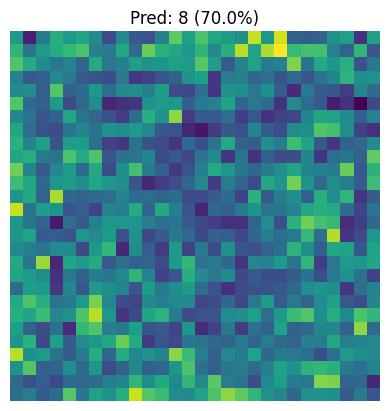

In [11]:
img = np.array(v)
img = img.reshape(1,28,28,1)

outputs = model_logit(img)

img = img.reshape(28,28)

probabilities = tf.nn.softmax(outputs, axis=1)

predictions = np.argmax(outputs, axis=1)
confidences = np.   max(probabilities, axis=1) * 100

print(predictions, confidences)

v.resize(28,28,1)
plt.imshow(v)
plt.title((f"Pred: {predictions[0]} ({confidences[0]:.1f}%)"))
plt.axis('off')
plt.show()

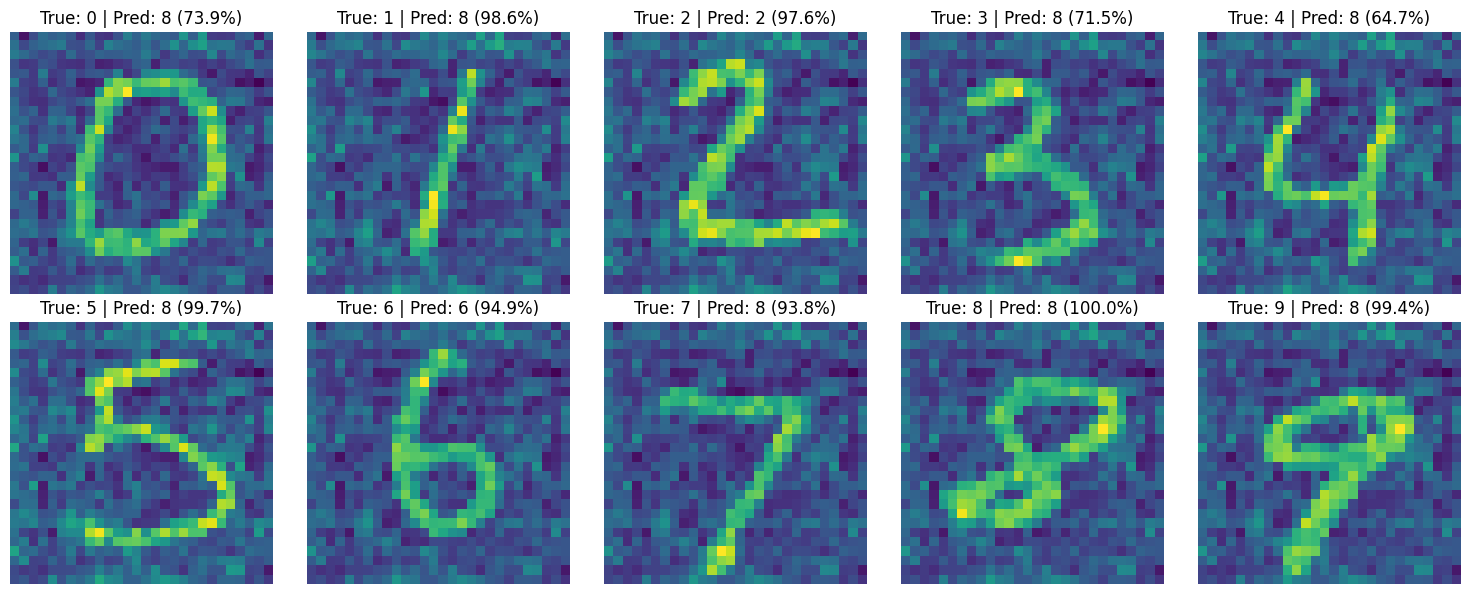

In [12]:
img_adv = []
predictionss = []
confidencess = []

for i in x_batch:
    img = np.array(i + v)
    img = img.reshape(1,28,28,1)

    outputs = model_logit(img)
    
    img = img.reshape(28,28)
    img_adv.append(img)

    probabilities = tf.nn.softmax(outputs, axis=1)

    predictions = np.argmax(outputs, axis=1)
    confidences = np.   max(probabilities, axis=1) * 100
    predictionss.append(predictions)
    confidencess.append(confidences)



# grille 2*5
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()


for i in range(10):
    axes[i].imshow(img_adv[i])
    axes[i].set_title(f'True: {i} | Pred: {predictionss[i][0]} ({confidencess[i][0]:.1f}%)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()